In [1]:
import tensorflow as tf
import keras
import numpy as np
import os
import json
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2024-01-12 13:23:57.125786: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
train_image_folder = '/raid/mpsych/OMAMA/DATA/data/train'
train_npz_folder = '/raid/mpsych/OMAMA/DATA/data/adjusted_2d_512'

In [3]:
# Get lists of image and npz files
image_files = [os.path.join(train_image_folder, f) for f in os.listdir(train_image_folder) if f.endswith('.png')]
npz_files = [os.path.join(train_npz_folder, f) for f in os.listdir(train_npz_folder) if f.endswith('.npz')]

In [4]:
image_files = image_files[:99999]

In [5]:
npz_files = npz_files[:99999]

In [8]:
# Split the dataset (adjust the test_size as needed)
train_files, test_files = train_test_split(list(zip(image_files, npz_files)), test_size=0.3, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

In [9]:
img_height = 512
img_width = 512
batch_size = 32

In [10]:
def custom_data_generator(file_list, batch_size, img_height, img_width):
    total_files = len(file_list)
    indices = np.arange(total_files)
    np.random.shuffle(indices)

    while True:
        for i in range(0, total_files, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_images = []
            batch_npz = []
            batch_labels = []

            for idx in batch_indices:
                img_file, npz_file = file_list[idx]

                # Process image file
                image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (img_width, img_height))
                image = np.expand_dims(image, axis=-1)
                image = image / 255.0 
                batch_images.append(image)

                # Process npz file
                with np.load(npz_file, allow_pickle=True) as data:
                    npz = data['data']
                npz = np.expand_dims(npz, axis=-1)
                if npz.max() != npz.min():
                    npz = (npz - npz.min()) / (npz.max() - npz.min())
                else:
                    npz = npz / npz.max()
                
                batch_npz.append(npz)

                # Assign class labels
                if img_file.endswith('.png'):
                    label = [1, 0]
                elif npz_file.endswith('.npz'):
                    label = [0, 1]
                else:
                    label = [0, 0]
                    
                batch_labels.append(label)
                

            combined_batch = np.concatenate((batch_images, batch_npz), axis=-1)
            yield (combined_batch, np.array(batch_labels))

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, mode='min')

In [12]:
NUMBER_OF_CLASSES = 2

In [13]:
# Create data generators
train_generator = custom_data_generator(train_files, batch_size, img_height, img_width)
val_generator = custom_data_generator(val_files, batch_size, img_height, img_width)
test_generator = custom_data_generator(test_files, batch_size, img_height, img_width)


In [15]:
# Modify the model for deeper architecture
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# Additional Convolutional layers
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# Flatten and Dense layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 510, 510, 32)      608       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 508, 508, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 254, 254, 64)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 254, 254, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 252, 252, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 126, 126, 128)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 126, 126, 128)    

In [16]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="adadelta",
              metrics=['accuracy'])

In [17]:
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_files) // batch_size,
        epochs=1,
        validation_data=val_generator,
        validation_steps=len(val_files) // batch_size,
        verbose=1,
        callbacks=[early_stopping]
    )
except Exception as e:
    print("An error occurred during training:", str(e))

2024-01-12 13:30:48.044863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-01-12 13:30:48.063172: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245720000 Hz
2024-01-12 13:31:01.474056: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-01-12 13:31:02.626999: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-01-12 13:31:04.201390: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-01-12 13:31:04.201416: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-01-12 13:31:04.202393: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modif

  23/2187 [..............................] - ETA: 15:39 - loss: 0.3774 - accuracy: 0.9087

/tmp/ipykernel_4021584/386405773.py:30: RuntimeWarning: invalid value encountered in true_divide
  npz = npz / npz.max()


2187/2187 [==============================] - 1199s 497ms/step - loss: 0.2091 - accuracy: 0.9979 - val_loss: 6.4376e-04 - val_accuracy: 1.0000


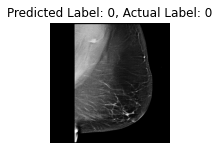

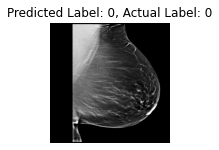

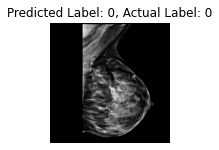

In [35]:
for i in range(3):
    test_sample, test_labels = next(test_generator)
    predictions = model.predict(test_sample)
    
    # Select an index from the batch to visualize
    sample_index = 1

    # Display the predicted label
    plt.subplot(2, 3, i+1)
    predicted_label = np.argmax(predictions[sample_index])
    actual_label = np.argmax(test_labels[sample_index])
    plt.title(f"Predicted Label: {predicted_label}, Actual Label: {actual_label}")
    plt.imshow(test_sample[sample_index, :, :, 0], cmap='gray') 
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# 0 for Synthetic and 1 for original